# VQE for Track Reconstruction - Final Task

This is a blueprint for your final task. It gives you some ideas of how to setup and plot things for:

In [1]:
from platform import python_version
import qiskit
import qiskit_optimization
print(f"Python: {python_version()}")
print(f"Qiskit: {qiskit.__qiskit_version__}")
print(f"Qiskit Optimization: {qiskit_optimization.__version__}")

Python: 3.10.4
Qiskit: {'qiskit-terra': '0.21.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': None}
Qiskit Optimization: 0.4.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

First the QUBO Matrix has to be set. 

Please make a drawing of tracks, corresponding to that QUBO matrix. That is an actual scenario, only the parameters are rounded!

In [3]:
QUBO_MATRIX = np.array([[ 0.1,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
                        [-1.0, -0.1,  0.0,  0.0,  0.0,  0.0,  0.0],
                        [ 0.0,  0.0, -0.1,  0.0,  0.0,  0.0,  0.0],
                        [ 0.0,  0.0, -1.0, -0.1,  0.0,  0.0,  0.0],
                        [ 1.0,  1.0,  1.0,  1.0,  0.1,  0.0,  0.0],
                        [ 1.0,  1.0,  1.0,  1.0,  1.0, -0.1,  0.0],
                        [ 0.0,  0.0,  1.0, -0.8,  1.0,  1.0,  0.1]])

In [4]:
from qiskit_optimization import QuadraticProgram

In [5]:
a_i = np.diag(QUBO_MATRIX)
b_ij = QUBO_MATRIX - np.diag(a_i)
print(f"linear term: \n{a_i}\n")
print(f"quadratic term: \n{b_ij}")

linear term: 
[ 0.1 -0.1 -0.1 -0.1  0.1 -0.1  0.1]

quadratic term: 
[[ 0.   0.   0.   0.   0.   0.   0. ]
 [-1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   0.   0. ]
 [ 0.   0.   1.  -0.8  1.   1.   0. ]]


In [6]:
size = len(a_i)

qubo = QuadraticProgram()
for i in range(size):
    qubo.binary_var(name='x' + str(i))
qubo.minimize(linear=a_i, quadratic=b_ij)

op, offset = qubo.to_ising()

print(qubo.prettyprint())

Problem name: 

Minimize
  -x0*x1 + x0*x4 + x0*x5 + x1*x4 + x1*x5 - x2*x3 + x2*x4 + x2*x5 + x2*x6 + x3*x4
  + x3*x5 - 0.8*x3*x6 + x4*x5 + x4*x6 + x5*x6 + 0.1*x0 - 0.1*x1 - 0.1*x2
  - 0.1*x3 + 0.1*x4 - 0.1*x5 + 0.1*x6

Subject to
  No constraints

  Binary variables (7)
    x0 x1 x2 x3 x4 x5 x6



## Numpy Eigensolver exact solution (for reference!)

Before solving the with VQE we solve it analytically by evaluating the minimum Eigenvalue, thus finding the ground state of the QUBO / Ising.

In [7]:
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit

ee = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = ee.solve(qubo).x

In [8]:
print('Result: ', result)
print('Energy: ', result.dot(QUBO_MATRIX.dot(result)))

Result:  [1. 1. 1. 1. 0. 0. 0.]
Energy:  -2.2


In [9]:
# qubo -> PauliSumOp for VQE
operator_list = []
for operator in op:
    aux_list = str(operator).split(' * ')
    t = tuple([aux_list[1], aux_list[0]])

    operator_list.append(t)

H = PauliSumOp.from_list(operator_list)

In [10]:
from qiskit.circuit.library.n_local.two_local import TwoLocal
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.algorithms.optimizers import COBYLA, SPSA, NFT, ADAM, L_BFGS_B, TNC

### ------------------
# optimizer = COBYLA(maxiter=4000)
# optimizer = SPSA(maxiter=500)       # takes some time ...
optimizer = NFT(maxfev=300)
# optimizer = ADAM(lr=1e-4, amsgrad=True)


### ------------------
# TwoLocal setup https://qiskit.org/documentation/stable/0.24/stubs/qiskit.circuit.library.TwoLocal.html
rotation_blocks = 'ry'
entanglement_blocks= 'cx'
repetitions = 1
entanglement = "full"
num_qubits = 7


ansatz = TwoLocal(num_qubits=num_qubits, 
                  rotation_blocks=rotation_blocks,
                  entanglement_blocks=entanglement_blocks, 
                  reps=repetitions, 
                  entanglement=entanglement,
                  insert_barriers=True)
ansatz.decompose().draw()


┌──────────┐ ░                                                        »
q_0: ┤ Ry(θ[0]) ├─░───■────■────■─────────■─────────■──────────────■───────»
     ├──────────┤ ░ ┌─┴─┐  │    │         │         │              │       »
q_1: ┤ Ry(θ[1]) ├─░─┤ X ├──┼────┼────■────┼────■────┼────■─────────┼────■──»
     ├──────────┤ ░ └───┘┌─┴─┐  │  ┌─┴─┐  │    │    │    │         │    │  »
q_2: ┤ Ry(θ[2]) ├─░──────┤ X ├──┼──┤ X ├──┼────┼────┼────┼────■────┼────┼──»
     ├──────────┤ ░      └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │    │  ┌─┴─┐  │    │  »
q_3: ┤ Ry(θ[3]) ├─░───────────┤ X ├───────┼──┤ X ├──┼────┼──┤ X ├──┼────┼──»
     ├──────────┤ ░           └───┘     ┌─┴─┐└───┘  │  ┌─┴─┐└───┘  │    │  »
q_4: ┤ Ry(θ[4]) ├─░─────────────────────┤ X ├───────┼──┤ X ├───────┼────┼──»
     ├──────────┤ ░                     └───┘     ┌─┴─┐└───┘       │  ┌─┴─┐»
q_5: ┤ Ry(θ[5]) ├─░───────────────────────────────┤ X ├────────────┼──┤ X ├»
     ├──────────┤ ░                               └───┘          ┌─┴─┐└───┘»
q_6: ┤ Ry(θ[6]) ├─░──────────────────────────────────────────────┤ X ├─────»
     └──────────┘ ░                                              └───┘     »
«                                                        ░  ┌──────────┐
«q_0: ───────────────────────────────────────────────────░──┤ Ry(θ[7]) ├
«                                                        ░  ├──────────┤
«q_1: ───────■───────────────────────────────────────────░──┤ Ry(θ[8]) ├
«            │                                           ░  ├──────────┤
«q_2: ──■────┼────■─────────■────────────────────────────░──┤ Ry(θ[9]) ├
«       │    │    │         │                            ░ ┌┴──────────┤
«q_3: ──┼────┼────┼────■────┼────■────■──────────────────░─┤ Ry(θ[10]) ├
«     ┌─┴─┐  │    │  ┌─┴─┐  │    │    │                  ░ ├───────────┤
«q_4: ┤ X ├──┼────┼──┤ X ├──┼────┼────┼────■────■────────░─┤ Ry(θ[11]) ├
«     └───┘  │  ┌─┴─┐└───┘  │  ┌─┴─┐  │  ┌─┴─┐  │        ░ ├───────────┤
«q_5: ───────┼──┤ X ├───────┼──┤ X ├──┼──┤ X ├──┼────■───░─┤ Ry(θ[12]) ├
«          ┌─┴─┐└───┘     ┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐┌─┴─┐ ░ ├───────────┤
«q_6: ─────┤ X ├──────────┤ X ├─────┤ X ├─────┤ X ├┤ X ├─░─┤ Ry(θ[13]) ├
«          └───┘          └───┘     └───┘     └───┘└───┘ ░ └───────────┘

## 1) Ideal Simulation

The last ingredient is the quantum instance. As backend we take the 'qasm_simulator', an ideal simulation without noise.
The number of shots is the number of repetitions of the evaluation of the quantum circuit.

In [11]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.algorithms import VQE
from qiskit.visualization import plot_histogram
from IPython.display import display, clear_output

In [12]:
# Ideal Sim backend
quantum_instance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), 
                                   shots=512,
                                   optimization_level=3,
                                   basis_gates= ["cx", "id", "rz", "sx", "x"],
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

In [13]:
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    try:
        display("Evaluation: {}, Energy: {}, Std: {}, Minimum = {}".format(eval_count, mean, std, min(values)))
    except:
        display("Evaluation: {}, Energy: {}, Std: {}, Minimum = NONE".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

In [14]:
ideal_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                quantum_instance=quantum_instance,
                callback=callback)

ideal_sim_result_vqe = ideal_vqe.compute_minimum_eigenvalue(H)

# CAREFUL!!! The following result has an offset, you need to subtract this offset, for this ISING/QUBO it is 2.25
# That means that the exact solution, given by the Numpy Eigensolver is actually -2.25 energy lower if we would convert it
# to the Ising model. But this is no problem since an offset will have no influence on the result state!

'Evaluation: 302, Energy: -4.439453125, Std: 0.007714978953275324, Minimum = -4.45'

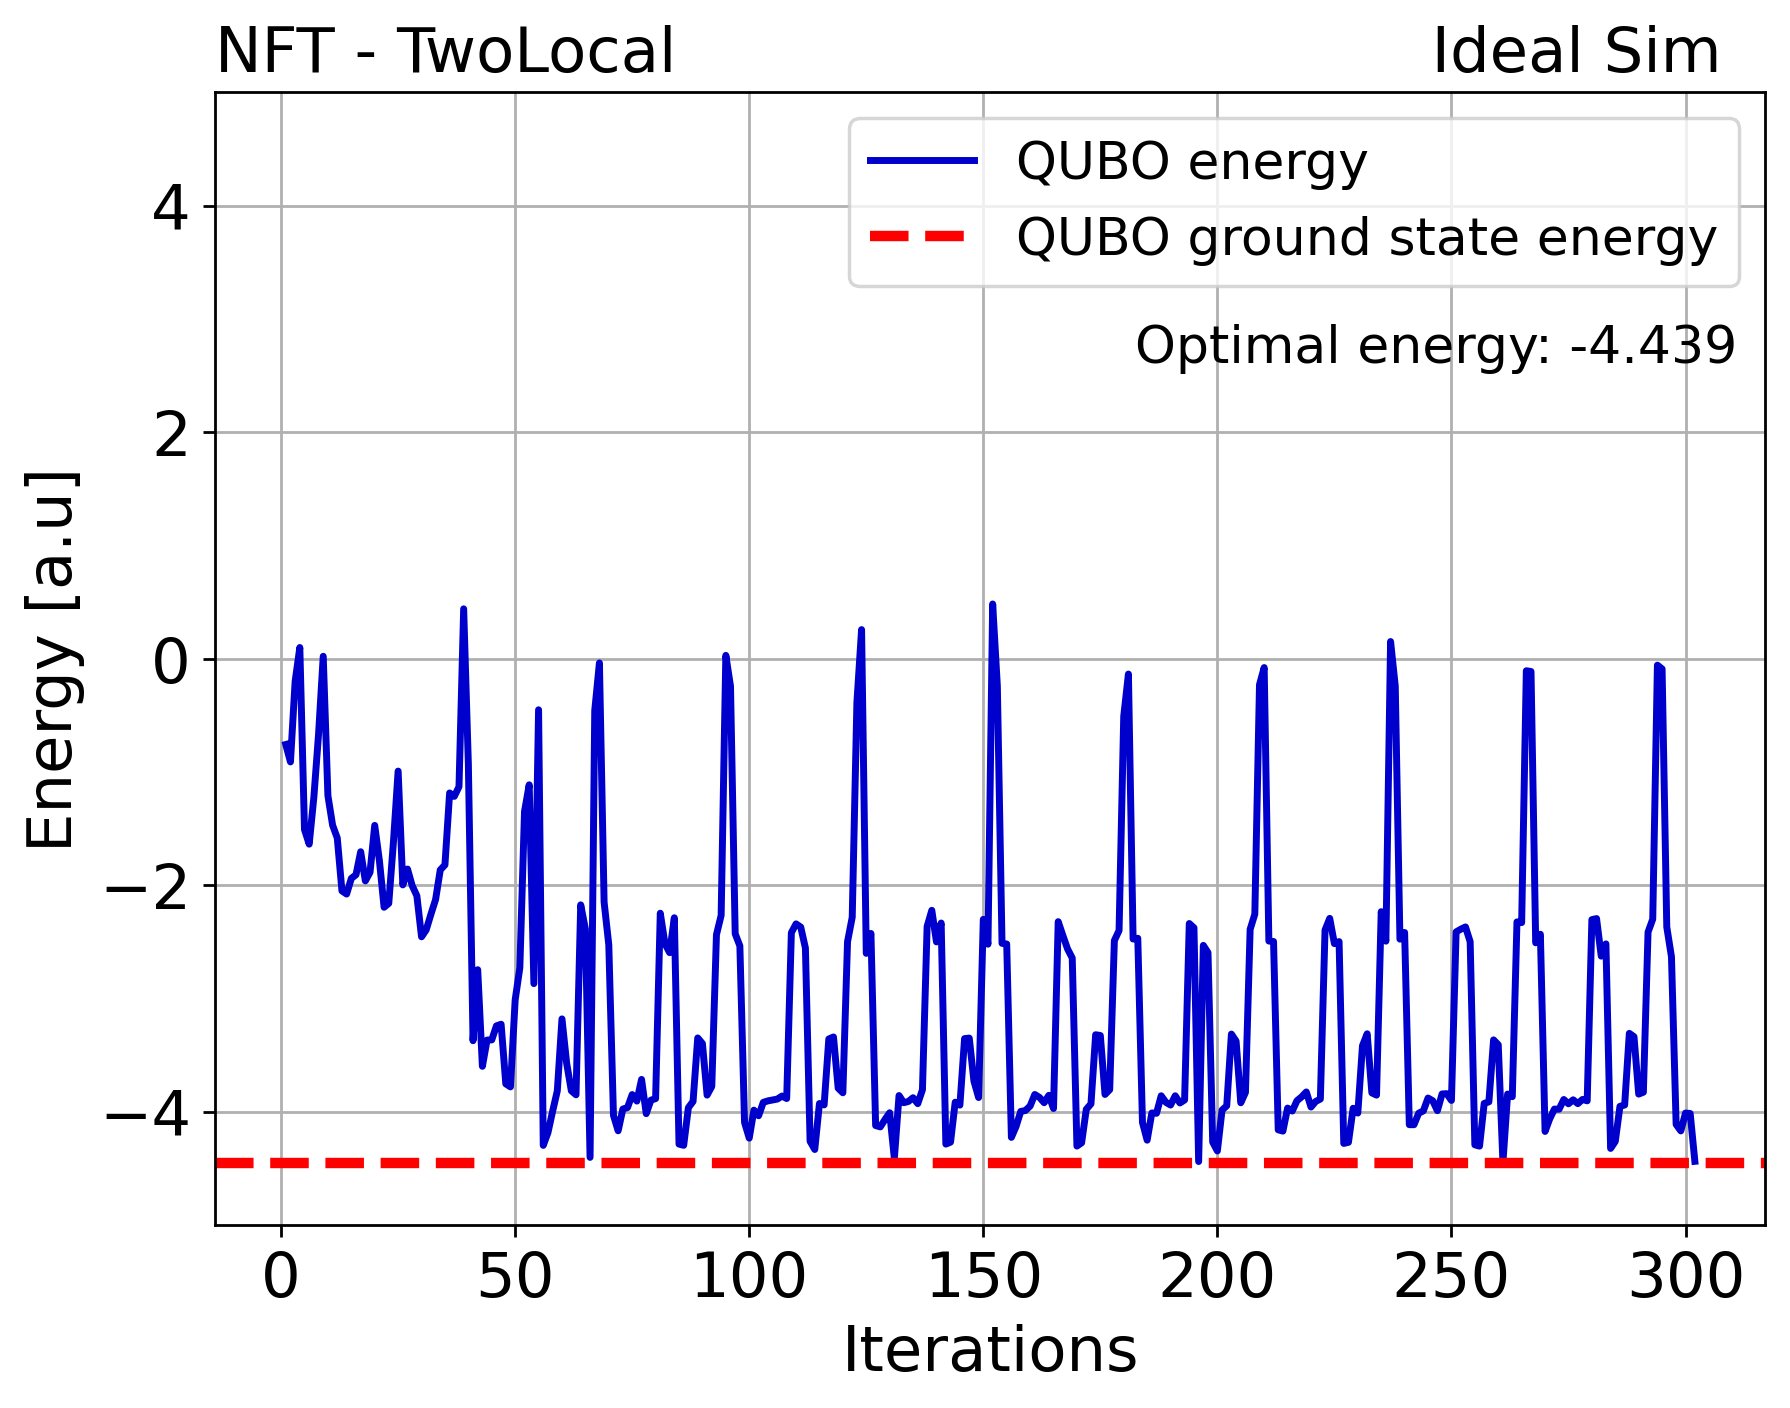

In [15]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)

accuracy_threshold = 4.0 # in mHa
energy = ideal_sim_result_vqe.optimal_value


result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'energy': energy,
    '# of parameters': len(ideal_sim_result_vqe.optimal_point),
    'final parameters': ideal_sim_result_vqe.optimal_point,
    '# of evaluations': ideal_sim_result_vqe.optimizer_evals,
    'optimizer time': ideal_sim_result_vqe.optimizer_time,
    '# of qubits': int(num_qubits)}

fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=250)
ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Energy [a.u]', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-5, 5)
ax.grid()
fig.text(0.585, 0.7, f'Optimal energy: {ideal_sim_result_vqe.optimal_value:.3f}', fontsize=15)
plt.title(f"{result_dict['optimizer']} - {result_dict['ansatz']}                                      Ideal Sim", 
          loc="left", fontsize=18)
ax.plot(counts, values, label="QUBO energy",linewidth=2, color="mediumblue")
ax.axhline(result.dot(QUBO_MATRIX.dot(result)) - offset, linestyle='--', label="QUBO ground state energy", color="red",
          linewidth=3)
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy']:.3f})-\
.pdf"
ax.legend(loc="best", fontsize=15)
fig.savefig(f"IdealSim-{fig_title}", dpi=600)

In [ ]:
def convert_to_probabilities(amplitude_dict):
    out_dict = {}
    for key  in amplitude_dict.keys():
        out_dict.update({key: amplitude_dict[key]**2})
    return out_dict

In [ ]:
fig = plot_histogram(convert_to_probabilities(ideal_sim_result_vqe.eigenstate),
                     legend=['Ideal Sim'],
                     figsize=(12, 6))
ax = fig.axes[0]
ax.legend(fontsize=16)
ax.set_ylabel("Predicitions", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig(f"PredicitonsIdealSim-{fig_title}", dpi=600)
fig

In [ ]:
np.save("result_ideal_sim", ideal_sim_result_vqe)

## 2) Solving the QUBO with VQE on a Fake Device


In [ ]:
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.fake_provider import FakeNairobi



quantum_instance = QuantumInstance(backend=QasmSimulator.from_backend(FakeNairobi()),
                                   shots=512,
                                   optimization_level=3,
                                   basis_gates= ["cx", "id", "rz", "sx", "x"],
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

counts = []
values = []
params = []
deviation = []

vqe_fake_device = VQE(ansatz=ansatz,
                      optimizer=optimizer,
                      quantum_instance=quantum_instance,
                      callback=callback)

vqe_result_fake_device = vqe_fake_device.compute_minimum_eigenvalue(H)

In [ ]:
# Unroller transpile your circuit into CNOTs and U gates
energy = vqe_result_fake_device.optimal_value


result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'energy': energy,
    '# of parameters': len(vqe_result_fake_device.optimal_point),
    'final parameters': vqe_result_fake_device.optimal_point,
    '# of evaluations': vqe_result_fake_device.optimizer_evals,
    'optimizer time': vqe_result_fake_device.optimizer_time,
    '# of qubits': int(num_qubits)}

fig2, ax2 = plt.subplots(1, 1, figsize=(8,6))
ax2.set_xlabel('Iterations', fontsize=18)
ax2.set_ylabel('Energy [a.u]', fontsize=18)
ax2.set_ylim(-5, 5)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.grid()
fig2.text(0.585, 0.7, f'Optimal energy: {vqe_result_fake_device.optimal_value:.3f}', fontsize=15)
plt.title(f"{result_dict['optimizer']} - {result_dict['ansatz']}                                  FakeNairobi", 
          loc="left", fontsize=18)
ax2.plot(counts, values, label="QUBO energy",linewidth=2, color="mediumblue")
ax2.axhline(result.dot(QUBO_MATRIX.dot(result)) - offset, linestyle='--', label="QUBO ground state energy", color="red",
          linewidth=3)
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy']:.3f})-\
.pdf"
ax2.legend(loc="best", fontsize=15)
fig2.savefig(f"FakeNairobi-{fig_title}", dpi=600)

In [ ]:
fig = plot_histogram([convert_to_probabilities(ideal_sim_result_vqe.eigenstate), 
                      convert_to_probabilities(vqe_result_fake_device.eigenstate)],
                     legend=['Ideal Sim', 'FakeNairobi'],
                     figsize=(12, 6))
ax = fig.axes[0]
ax.legend(fontsize=16)
ax.set_ylabel("Predicitions", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig(f"PredicitonsFakeNairobi-{fig_title}", dpi=600)
fig

In [ ]:
np.save("result_vqe_fake_nairobi", vqe_result_fake_device)

### 3) Solving the QUBO with VQE on a real quantum device

Before you start this section:

    - Create an account at IBM at https://quantum-computing.ibm.com/. You need to have an API token in order to start computing on their devices. Don't worry, it's for free unless you want to pay for priority or better devices.

    - make sure you have chosen an optimal setup! It needs to be fast and give you a good result. Otherwise you wiill have to wait O(days) for your result, because you have no priority on the devices and have to share them with many other people.
    
    - after you have your results, please save them immediately. The print statements displays the results that are most important. A high resolution screenshot is appreciated to for starters ;-)

In [ ]:
from qiskit import IBMQ

In [ ]:
IBMQ.load_account()

In [ ]:

counts = []
values = []
params = []
deviation = []

quantum_instance_ibmq = QuantumInstance(backend=IBMQ.get_provider(hub='ibm-q').get_backend('ibm_nairobi'), 
                                        shots=512,
                                        optimization_level=3,
                                        measurement_error_mitigation_cls=CompleteMeasFitter,
                                        cals_matrix_refresh_period=30)
vqe_ibm = VQE(ansatz=ansatz,
              optimizer=optimizer,
              quantum_instance=quantum_instance_ibmq,
              callback=callback)



result_vqe_ibm = vqe_ibm.compute_minimum_eigenvalue(H)

In [ ]:
# Unroller transpile your circuit into CNOTs and U gates
energy = result_vqe_ibm.optimal_value


result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'energy': energy,
    '# of parameters': len(result_vqe_ibm.optimal_point),
    'final parameters': result_vqe_ibm.optimal_point,
    '# of evaluations': result_vqe_ibm.optimizer_evals,
    'optimizer time': result_vqe_ibm.optimizer_time,
    '# of qubits': int(num_qubits)}

fig3, ax3 = plt.subplots(1, 1, figsize=(8,6))
ax3.set_xlabel('Iterations', fontsize=18)
ax3.set_ylabel('Energy [a.u]', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.grid()
ax3.set_ylim(-5, 5)
fig3.text(0.585, 0.7, f'Optimal energy: {result_vqe_ibm.optimal_value:.3f}', fontsize=15)
plt.title(f"{result_dict['optimizer']} - {result_dict['ansatz']}                                  IBMNairobi", 
          loc="left", fontsize=18)
ax3.plot(counts, values, label="QUBO energy",linewidth=2, color="mediumblue")
ax3.axhline(result.dot(QUBO_MATRIX.dot(result)) - offset, linestyle='--', label="QUBO ground state energy", color="red",
          linewidth=3)
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy']:.3f})-\
.pdf"
ax3.legend(loc="best", fontsize=15)
fig3.savefig(f"IBMNairobi-{fig_title}", dpi=600)

In [ ]:
fig = plot_histogram([convert_to_probabilities(ideal_sim_result_vqe.eigenstate), 
                      convert_to_probabilities(vqe_result_fake_device.eigenstate),
                     convert_to_probabilities(result_vqe_ibm.eigenstate)],
                     legend=['Ideal Sim', 'FakeNairobi', "IBMNairobi"],
                     number_to_keep=10,
                     figsize=(18, 6),)
ax = fig.axes[0]
ax.legend(fontsize=16)
ax.set_ylabel("Predicitions", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig(f"PredicitonsIBMNairobi-{fig_title}", dpi=600)
fig

# Congratulations! 

# You completed your first track reconstruction task on a real quantum device. AWESOME!

In [ ]:
np.save("result_vqe_ibm", result_vqe_ibm)